In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing and Importing Libraries

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from rasterio.enums import Resampling

# **Random Forest**

---



# Importing geojson points

In [ ]:
# Paths to datasets
geojson_path = '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Au_Cu_Zn_Pb_alterations_filtered_rockchip_samples.geojson'

geo_data = gpd.read_file(geojson_path)

In [ ]:
# Important columns
relevant_columns = [
    'Argillic_PCA1_Proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj',
    'Iron-oxide_PCA1_proj',
    'classvalue'  # Target column
]

# Select relevant columns
selected_data = geo_data[relevant_columns]

# Original, oversampling and undersampling data
N.B the Dataset is imbalanced, to overcome this problem different resampling are applied

In [ ]:
# Splitting data
# Separate features and target from the original dataset
X = selected_data.drop('classvalue', axis=1)  # Features
y = selected_data['classvalue']  # Target

# Step 1: Split the data into training (70%), test (15%), validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Function to print class distribution
def print_class_distribution(data, label):
    print(f"###### {label} ###########")
    print("Class Distribution:\n", data.value_counts())

# 1. Original Data
# Check class distribution of the original data
print_class_distribution(y_train, "Original Training Data")
print_class_distribution(y_test, "Original Test Data")
print_class_distribution(y_val, "Original Validation Data")

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print_class_distribution(y_train_smote, "Oversampled Training Data")

# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Check class distribution after undersampling
print_class_distribution(y_train_under, "Undersampled Training Data")

###### Original Training Data ###########
Class Distribution:
 classvalue
0    1194
1     237
Name: count, dtype: int64
###### Original Test Data ###########
Class Distribution:
 classvalue
0    149
1     30
Name: count, dtype: int64
###### Original Validation Data ###########
Class Distribution:
 classvalue
0    150
1     29
Name: count, dtype: int64
###### Oversampled Training Data ###########
Class Distribution:
 classvalue
0    1194
1    1194
Name: count, dtype: int64
###### Undersampled Training Data ###########
Class Distribution:
 classvalue
0    237
1    237
Name: count, dtype: int64


# Training the 3 models

In [ ]:
#1. Original data
model_original_RF = RandomForestClassifier(random_state=42, bootstrap= True, class_weight= 'balanced', criterion= 'entropy', max_depth= 15, max_features= None, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100)
model_original_RF.fit(X_train, y_train)
joblib.dump(model_original_RF, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_original_tunned_param.pkl')

# 2. Oversampling using SMOTE
model_smote_RF = RandomForestClassifier(random_state=42,bootstrap= True, class_weight= 'balanced', criterion = 'entropy', max_depth= 15, max_features= None, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 200)
model_smote_RF.fit(X_train_smote, y_train_smote)
joblib.dump(model_smote_RF, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_smote_tunned_param.pkl')

# 3. Undersampling using RandomUnderSampler
model_under_RF = RandomForestClassifier(random_state=42,bootstrap= True, class_weight= 'balanced', criterion='entropy', max_depth= 15, min_samples_leaf= 5, n_estimators=100)
model_under_RF.fit(X_train_under, y_train_under)
joblib.dump(model_under_RF, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_undersampling_tunned_param.pkl')

print ("Model trained and saved")

Model trained and saved


# Evaluation the models on test and validation data

In [ ]:
# Models and their datasets
models = {
    "Original Data": (model_original_RF, X_train, X_test, y_train, y_test),
    "SMOTE Oversampling": (model_smote_RF, X_train_smote, X_test, y_train_smote, y_test),
    "Random Undersampling": (model_under_RF, X_train_under, X_test, y_train_under, y_test)
}

# Function to evaluate a model on a given dataset
def evaluate_model(model, X, y, dataset_name):
    print(f"##### {dataset_name} Evaluation #####")
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print('\nClassification Report:')
    print(classification_report(y, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y, y_pred))
    print("\n" + "#" * 50 + "\n")

# Evaluate models on training, testing, and validation datasets
for model_name, (model, X_train_data, X_test_data, y_train_data, y_test_data) in models.items():
    print(f"\n\n===== Evaluating {model_name} Model =====")

    # Evaluate on training data
    evaluate_model(model, X_train_data, y_train_data, f"{model_name} - Training Data")

    # Evaluate on test data
    evaluate_model(model, X_test_data, y_test_data, f"{model_name} - Test Data")

    # Evaluate on validation data (if available)
    if 'X_val' in globals() and 'y_val' in globals():
        evaluate_model(model, X_val, y_val, f"{model_name} - Validation Data")



===== Evaluating Original Data Model =====
##### Original Data - Training Data Evaluation #####
Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1194
           1       0.85      0.91      0.88       237

    accuracy                           0.96      1431
   macro avg       0.92      0.94      0.93      1431
weighted avg       0.96      0.96      0.96      1431

Confusion Matrix:
[[1156   38]
 [  22  215]]

##################################################

##### Original Data - Test Data Evaluation #####
Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       149
           1       0.59      0.63      0.61        30

    accuracy                           0.87       179
   macro avg       0.76      0.77      0.77       179
weighted avg       0.87      0.87      0.87       179

Confusion Matrix:
[[136

# Feature Importance

                Feature  Importance
3  Iron-oxide_PCA1_proj    0.392009
1     Phyllic_PCA1_proj    0.247239
2  Propylitic_PCA1_proj    0.201295
0    Argillic_PCA1_Proj    0.159457


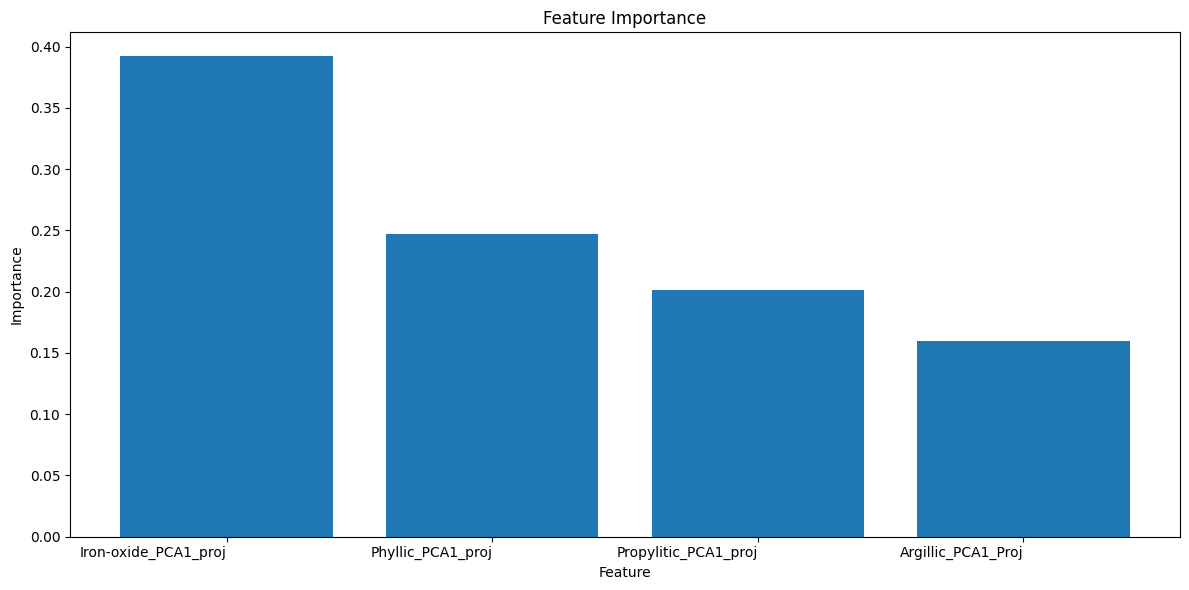

In [ ]:
# Assuming you have feature names
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Extract feature importance
feature_importances = model_original_RF.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

# Plot feature importance (vertical bar chart)
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])  # Fixed typo here
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=0, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## F1-score

F1-Score for Original Data: 0.7541
F1-Score for SMOTE Oversampling: 0.8136
F1-Score for Random Undersampling: 0.7937


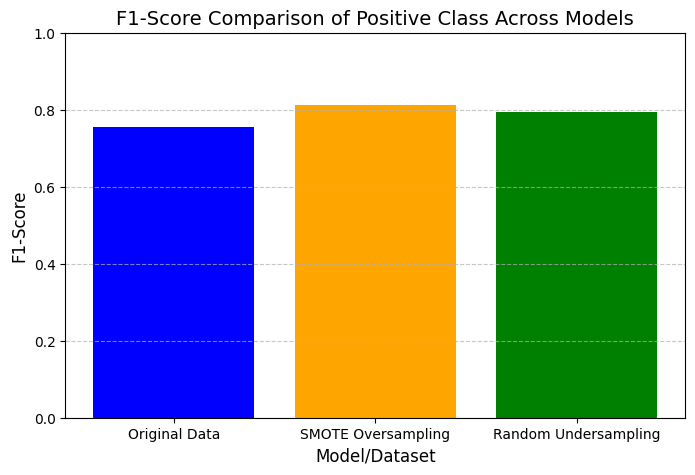

In [ ]:
# Store F1-scores for the positive class
f1_scores = {}

# Iterate through models and calculate F1-score
for model_name, (model, X_train, X_test, y_train, y_test) in models.items():
    # Fit the model
    model.fit(X_test, y_test)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Calculate F1-score for the positive class (assuming 1 is the positive class)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores[model_name] = f1
    print(f"F1-Score for {model_name}: {f1:.4f}")

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'orange', 'green'])
plt.title("F1-Score Comparison of Positive Class Across Models", fontsize=14)
plt.ylabel("F1-Score", fontsize=12)
plt.xlabel("Model/Dataset", fontsize=12)
plt.ylim(0, 1)  # F1-score ranges between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Precision-Recall Curve Comparison for RF model

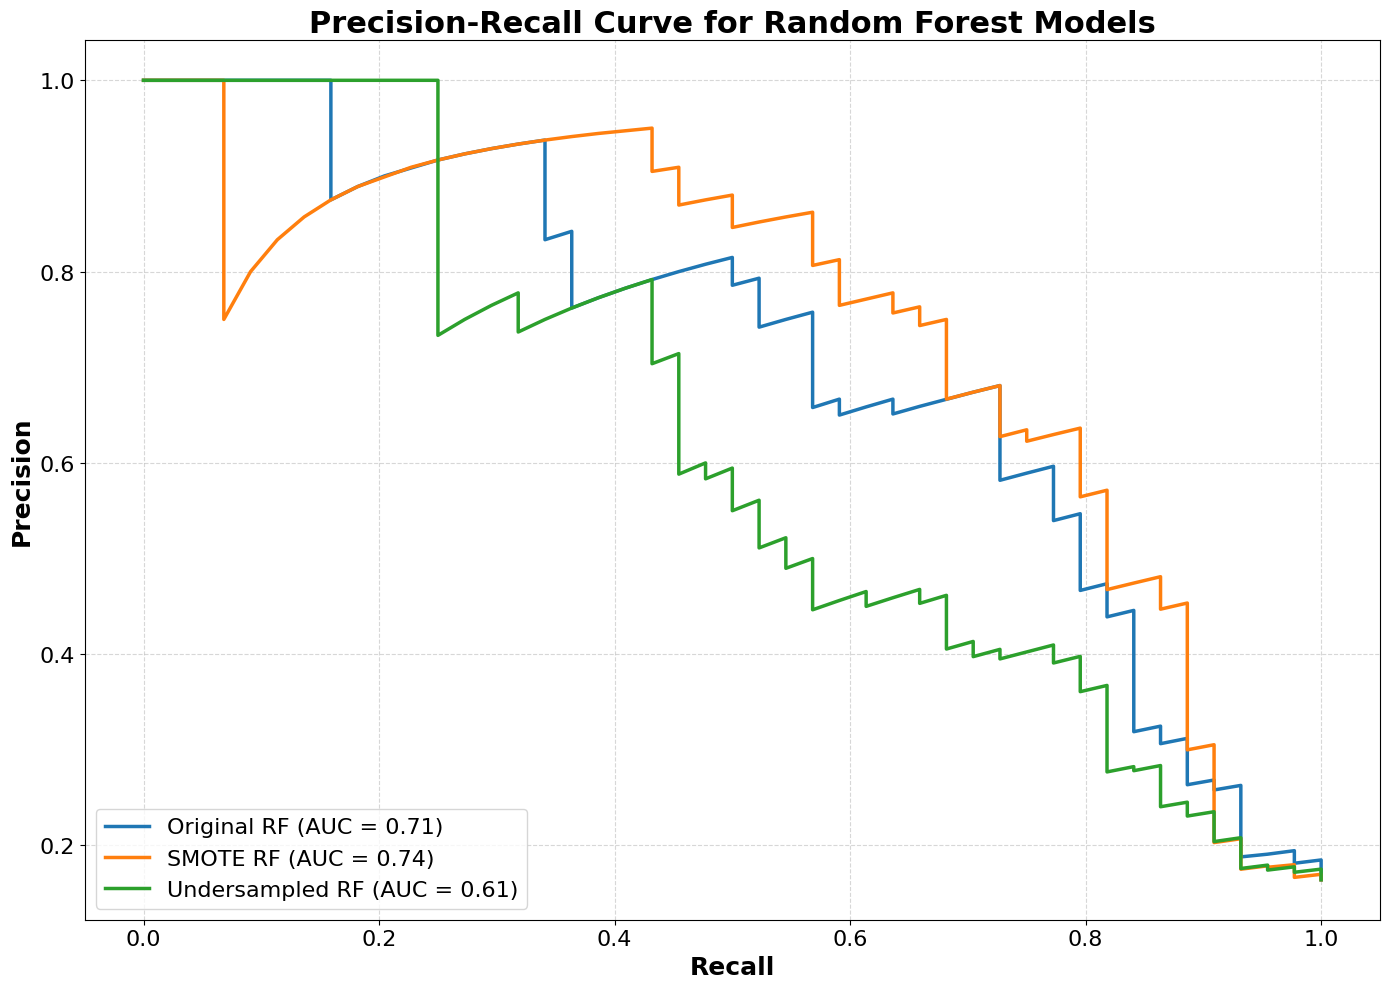

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Assuming X_test and y_test are available and the models are loaded
models = {
    "Original RF": model_original_RF,
    "SMOTE RF": model_smote_RF,
    "Undersampled RF": model_under_RF,
}

# Initialize the plot with larger size
plt.figure(figsize=(14, 10))

# Loop through each model and compute the Precision-Recall curve
for model_name, model in models.items():
    # Predict probabilities for the positive class
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probability of Class 1

    # Compute Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve
    plt.plot(recall, precision, linewidth=2.5, label=f"{model_name} (AUC = {pr_auc:.2f})")


plt.title("Precision-Recall Curve for Random Forest Models", fontsize=22, fontweight='bold')  # Larger title
plt.xlabel("Recall", fontsize=18, fontweight='bold')  # Larger X-axis label
plt.ylabel("Precision", fontsize=18, fontweight='bold')  # Larger Y-axis label

# Adjust tick labels for better visibility
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Enable grid with better visibility
plt.grid(alpha=0.5, linestyle="--")

# Increase legend size
plt.legend(loc="lower left", fontsize=16)

# Ensure labels are not cut off
plt.tight_layout()

# Show the plot
plt.show()


# Predicting the map

In [ ]:
from rasterio.enums import Resampling
import numpy as np

# Function to resample raster to match the reference raster
def resample_raster(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_meta = ref.meta
        ref_transform = ref.transform
        ref_shape = (ref.height, ref.width)

    with rasterio.open(source_path) as src:
        data = src.read(
            1,
            out_shape=ref_shape,
            resampling=Resampling.bilinear
        )
        transform = src.transform

    return data, ref_meta

# File paths for the input rasters
raster_files = [
    '/content/drive/MyDrive/classification/sample_data/Argillic_PCA1_Proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Iron-oxide_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Phyllic_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Propylitic_PCA1_proj.tif'
]

# Reference raster for resampling (use the first raster as a reference)
reference_raster = raster_files[0]

# Resample rasters
resampled_rasters = []
meta = None

for file in raster_files:
    resampled_data, meta = resample_raster(file, reference_raster)
    resampled_rasters.append(resampled_data)

# Stack the resampled rasters to form a feature array
stacked_data = np.stack(resampled_rasters, axis=-1)

# Flatten the data to create input features for the model
rows, cols, bands = stacked_data.shape
input_features = stacked_data.reshape(-1, bands)

# Match the feature names to those used during training
columns = [
    'Argillic_PCA1_Proj',
    'Iron-oxide_PCA1_proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj'
]
input_features_df = pd.DataFrame(input_features, columns=columns)

# Load the trained models
models = {
    "Original": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_original_tunned_param.pkl',
    "Oversampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_smote_tunned_param.pkl',
    "Undersampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_undersampling_tunned_param.pkl'
}


for i, (model_name, model_path) in enumerate(models.items()):
    # Load the model
    model = joblib.load(model_path)


    # Get the expected feature order and reorder input features
    expected_feature_order = model.feature_names_in_
    input_features_df = input_features_df[expected_feature_order]

    # Predict the class values
    predicted_class = model.predict(input_features_df)

    # Reshape predictions back to the raster shape
    predicted_raster = predicted_class.reshape(rows, cols)

    # Save the prediction result as a new raster file
    output_file = f'/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Predicted_map/RF/predicted_class_RF_map_{model_name.lower().replace(" ", "_")}_train_test_val_tunned_param.tif'
    meta.update(
        dtype=rasterio.uint8,  # Ensure correct data type
        count=1,              # Number of bands
        nodata=255            # Set nodata to a valid value for uint8
    )
print ("Map saved")


Map saved


# K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Define the F1-score scorer for the minor class
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

# 1. On Original Data
f1_scores_original = cross_val_score(estimator=model_original_RF, X=X_train, y=y_train, cv=10, scoring=f1_scorer)
print(f"F1-scores (Original Data): {f1_scores_original}")
print(f"The mean F1-score is: {f1_scores_original.mean()}")
print(f"The std F1-score is: {f1_scores_original.std()}")
print("\n" + "#" * 50 + "\n")

# 2. On Oversampled Data
f1_scores_smote = cross_val_score(estimator=model_smote_RF, X=X_train_smote, y=y_train_smote, cv=10, scoring=f1_scorer)
print(f"F1-scores (SMOTE Data): {f1_scores_smote}")
print(f"The mean F1-score of SMOTE is: {f1_scores_smote.mean()}")
print(f"The std F1-score of SMOTE is: {f1_scores_smote.std()}")
print("\n" + "#" * 50 + "\n")

# 5. On Undersampled Data
f1_scores_under = cross_val_score(estimator=model_under_RF, X=X_train_under, y=y_train_under, cv=10, scoring=f1_scorer)
print(f"F1-scores (Undersampled Data): {f1_scores_under}")
print(f"The mean F1-score of undersampling is: {f1_scores_under.mean()}")
print(f"The std F1-score of undersampling is: {f1_scores_under.std()}")


F1-scores (Original Data): [0.84444444 0.73913043 0.82608696 0.76923077 0.71111111 0.85714286
 0.61538462 0.69565217 0.79069767 0.89795918]
The mean F1-score is: 0.7746840220623262
The std F1-score is: 0.08168175117388468

##################################################

F1-scores (SMOTE Data): [0.8722467  0.86666667 0.89256198 0.91286307 0.925      0.8907563
 0.92436975 0.90456432 0.89177489 0.90295359]
The mean F1-score of SMOTE is: 0.8983757260758051
The std F1-score of SMOTE is: 0.018647510870772085

##################################################

F1-scores (Undersampled Data): [0.88888889 0.69387755 0.79069767 0.7755102  0.73913043 0.84444444
 0.6        0.71111111 0.79069767 0.80769231]
The mean F1-score of undersampling is: 0.7642050290858611
The std F1-score of undersampling is: 0.07795129551310778


# Grid Search

In [ ]:
#Applying Grid search to find the best model and the best parameters
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Define a custom scorer for F1-score of Class 1
f1_class1_scorer = make_scorer(f1_score, pos_label=1)

parameters_original = [
    {'n_estimators': [50, 100, 200, 400, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 15, 20, 25 None],
    'min_samples_split': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [0.5, 1, 1.5, 2, 'sqrt'],
    'class_weight': ['balanced', None]
     }
]
grid_search_original = GridSearchCV(estimator = model_original_RF,
                           param_grid = parameters_original,
                           scoring = f1_class1_scorer,
                           cv = 10,
                           n_jobs = -1)
grid_search_original.fit(X_train, y_train)
best_accuracy_original = grid_search_original.best_score_
best_parameters_original = grid_search_original.best_params_
print (best_parameters_original)
#####################################################################
grid_search_smote = GridSearchCV(estimator = model_smote_RF,
                           param_grid = parameters_original,
                           scoring = f1_class1_scorer,
                           cv = 10,
                           n_jobs = -1)
grid_search_smote.fit(X_train_smote, y_train_smote)
best_accuracy_smote = grid_search_smote.best_score_
best_parameters_smote = grid_search_smote.best_params_
print (best_parameters_smote)
#####################################################################
grid_search_under = GridSearchCV(estimator = model_under_RF,
                           param_grid = parameters_original,
                           scoring = f1_class1_scorer,
                           cv = 10,
                           n_jobs = -1)
grid_search_under.fit(X_train_under, y_train_under)
best_accuracy_under = grid_search_under.best_score_
best_parameters_under = grid_search_under.best_params_
print (best_parameters_under)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 600}


# **SVM**

---



# Importing Geojson points

In [ ]:
# Paths to geojson
geojson_path = '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Au_Cu_Zn_Pb_alterations_filtered_rockchip_samples.geojson'



geo_data = gpd.read_file(geojson_path)
geo_data.head()


,fid,Easting,Northing,Elv,Au_ppb,Cu_ppm,Pb_ppm,Zn_ppm,Phyllic_PCA1_proj,Iron-oxide_PCA1_proj,Argillic_PCA1_Proj,Propylitic_PCA1_proj,classvalue,classvalue1,geometry
0,1,410736.0,1921892.0,NaN,2.0,25,4,58,2.40117,2.18944,1.63973,2.92081,0,0,POINT (410736 1921892)
1,2,410213.0,1921764.0,NaN,2.0,20,3,54,2.36735,2.30059,1.66190,3.08944,0,0,POINT (410213 1921764)
2,3,410011.0,1921640.0,NaN,2.0,17,4,82,2.36837,2.03928,1.64166,3.17673,0,0,POINT (410011 1921640)
3,4,410450.0,1921097.0,NaN,4.0,19,4,52,2.47477,2.22484,1.69066,2.90041,0,0,POINT (410450 1921097)
4,5,411269.0,1921818.0,NaN,2.0,39,4,49,2.50653,2.24257,1.77048,2.84143,0,0,POINT (411269 1921818)


In [ ]:
# Relevant columns
relevant_columns = [
    'Argillic_PCA1_Proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj',
    'Iron-oxide_PCA1_proj',
    'classvalue'  # Target column
]

# Select relevant columns
selected_data = geo_data[relevant_columns]


## Original, Oversampled and Under-sampled Training data

In [ ]:
# Spliting data
# Separate features and target from the original dataset
X = selected_data.drop('classvalue', axis=1)  # Features
y = selected_data['classvalue']  # Target

# Step 1: Split the data into training (70%), test (15%), validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)


# 1. Original Data
# Check class distribution of the original data
print ("######Original Data###########")
print("Before:", y_train.value_counts())
print("After:", y_train.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print ("########Oversampling###########")
print("Before:", y_train.value_counts())
print("After Oversampling:", y_train_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
# Check class distribution after undersampling
print ("#######under sampling###########")
print("Before:", y_train.value_counts())
print("After undersampling:", y_train_under.value_counts())


######Original Data###########
Before: classvalue
0    1194
1     237
Name: count, dtype: int64
After: classvalue
0    1194
1     237
Name: count, dtype: int64
########Oversampling###########
Before: classvalue
0    1194
1     237
Name: count, dtype: int64
After Oversampling: classvalue
0    1194
1    1194
Name: count, dtype: int64
#######under sampling###########
Before: classvalue
0    1194
1     237
Name: count, dtype: int64
After undersampling: classvalue
0    237
1    237
Name: count, dtype: int64


# Training the models

In [ ]:
# 1. Original data
model_original_SVM = SVC(random_state=42,C= 9.6, gamma = 0.9999999999999996, kernel= 'rbf')
model_original_SVM.fit(X_train, y_train)
# Save the model
joblib.dump(model_original_SVM, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_original.pkl')

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote_SVM = SVC(random_state=42,C= 44.50000000000001, gamma = 0.9799999999999995, kernel= 'rbf')
model_smote_SVM.fit(X_train_smote, y_train_smote)
# Save the model
joblib.dump(model_smote_SVM, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_smote.pkl')

# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
model_under_SVM = SVC(random_state=42, C= 9.6, gamma = 0.9999999999999996, kernel= 'rbf')
model_under_SVM.fit(X_train_under, y_train_under)

# Save the model
joblib.dump(model_under_SVM, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_undersampling.pkl')

print("Models trained and saved with SVM classifier.")




Models trained and saved with SVM classifier.


# Test and Validation data aster resampling technique applied


In [ ]:
# 1. Original Data
# Check class distribution of the original test
print ("######Original Test Data###########")
print(y_test.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

# Check class distribution after oversampling
print ("########Oversampling Test ###########")
print("After Oversampling:", y_test_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_test_under, y_test_under = undersampler.fit_resample(X_test, y_test)
# Check class distribution after undersampling
print ("#######under sampling Test###########")
print("After undersampling:", y_test_under.value_counts())
###############################################################################
# 1. Original Data
# Check class distribution of the original test
print ("######Original val Data###########")
print(y_val.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

# Check class distribution after oversampling
print ("########Oversampling val ###########")
print("After Oversampling:", y_val_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_val_under, y_val_under = undersampler.fit_resample(X_val, y_val)
# Check class distribution after undersampling
print ("#######under sampling val###########")
print("After undersampling:", y_val_under.value_counts())

######Original Test Data###########
classvalue
0    149
1     30
Name: count, dtype: int64
########Oversampling Test ###########
After Oversampling: classvalue
0    149
1    149
Name: count, dtype: int64
#######under sampling Test###########
After undersampling: classvalue
0    30
1    30
Name: count, dtype: int64
######Original val Data###########
classvalue
0    150
1     29
Name: count, dtype: int64
########Oversampling val ###########
After Oversampling: classvalue
0    150
1    150
Name: count, dtype: int64
#######under sampling val###########
After undersampling: classvalue
0    29
1    29
Name: count, dtype: int64


# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models and their datasets
models = {
    "Original Data": (model_original_SVM, X_train, X_test, y_train, y_test),
    "SMOTE Oversampling": (model_smote_SVM, X_train_smote, X_test_smote, y_train_smote, y_test_smote),
    "Random Undersampling": (model_under_SVM, X_train_under, X_test_under, y_train_under, y_test_under)
}

# Function to evaluate a model and its dataset
def evaluate_model(model, X_train, X_test, y_train, y_test, data_type="Train"):
    print(f"{data_type} data evaluation")
    y_pred = model.predict(X_train if data_type == "Train" else X_test)
    accuracy = accuracy_score(y_train if data_type == "Train" else y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    report = classification_report(y_train if data_type == "Train" else y_test, y_pred)
    print('\nClassification Report')
    print(report)
    cm = confusion_matrix(y_train if data_type == "Train" else y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\n" + "#" * 50 + "\n")

# Loop through models and datasets to evaluate
for model_name, (model, X_train, X_test, y_train, y_test) in models.items():
    evaluate_model(model, X_train, X_test, y_train, y_test, data_type="Train")
    evaluate_model(model, X_train, X_test, y_train, y_test, data_type="Test")


Train data evaluation
Accuracy: 0.94

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1194
           1       0.92      0.71      0.80       237

    accuracy                           0.94      1431
   macro avg       0.93      0.85      0.88      1431
weighted avg       0.94      0.94      0.94      1431

Confusion Matrix:
[[1179   15]
 [  69  168]]

##################################################

Test data evaluation
Accuracy: 0.88

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       149
           1       0.74      0.47      0.57        30

    accuracy                           0.88       179
   macro avg       0.82      0.72      0.75       179
weighted avg       0.87      0.88      0.87       179

Confusion Matrix:
[[144   5]
 [ 16  14]]

##################################################

Train data evaluation
Accuracy: 0.9

## F1-score

F1-Score for Original Data: 0.3590
F1-Score for SMOTE Oversampling: 0.7666
F1-Score for Random Undersampling: 0.7037


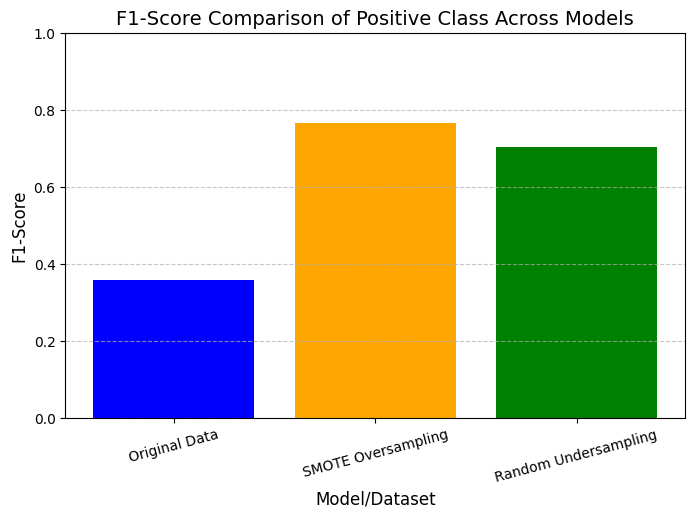

In [ ]:
from sklearn.metrics import f1_score

# Store F1-scores for the positive class
f1_scores = {}

# Iterate through models and calculate F1-score
for model_name, (model, X_train, X_test, y_train, y_test) in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Calculate F1-score for the positive class (assuming 1 is the positive class)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores[model_name] = f1
    print(f"F1-Score for {model_name}: {f1:.4f}")

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'orange', 'green'])
plt.title("F1-Score Comparison of Positive Class Across Models", fontsize=14)
plt.ylabel("F1-Score", fontsize=12)
plt.xlabel("Model/Dataset", fontsize=12)
plt.ylim(0, 1)  # F1-score ranges between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.show()


## Precision Recall on test data

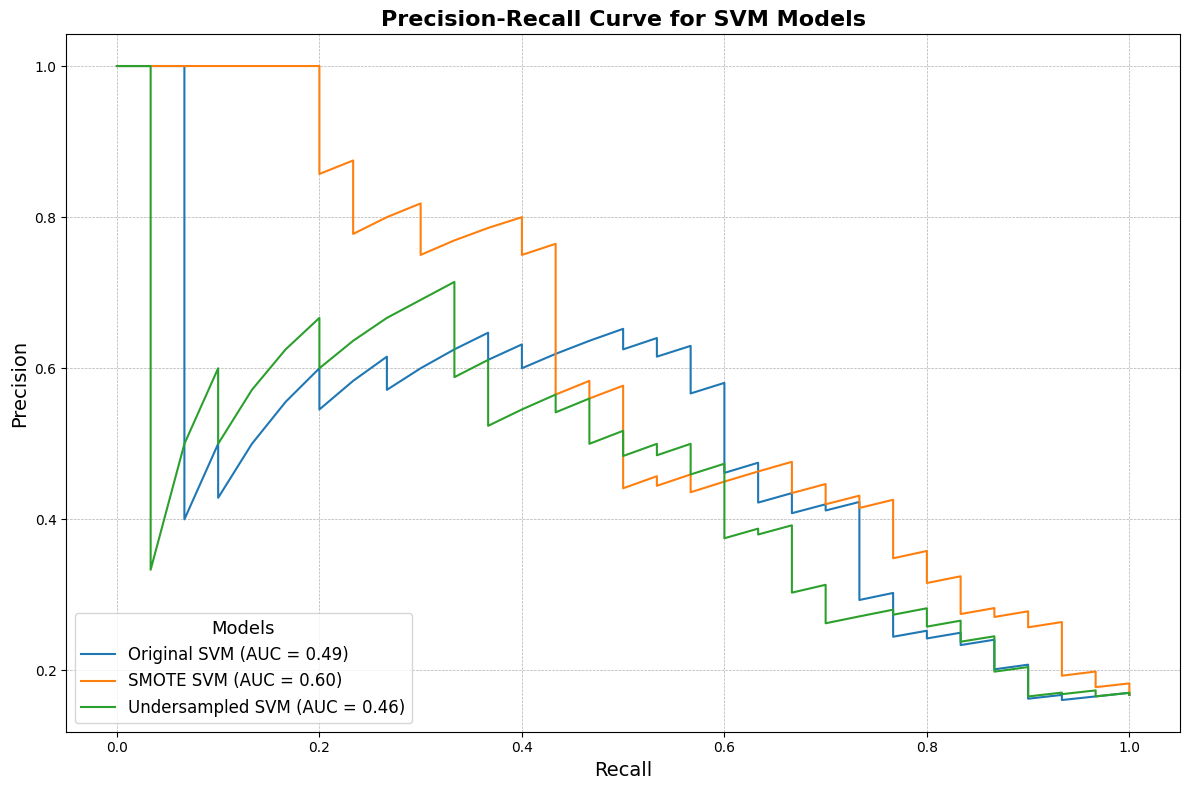

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
# Enable Probabilities
model_original_SVM = SVC(probability=True)
model_smote_SVM = SVC(probability=True)
model_under_SVM = SVC(probability=True)

# Train each model
model_original_SVM.fit(X_train, y_train)  # Fit the original model
model_smote_SVM.fit(X_train_smote, y_train_smote)  # Fit the SMOTE model
model_under_SVM.fit(X_train_under, y_train_under)  # Fit the undersampled model

# Define models dictionary after training
models = {
    "Original SVM": model_original_SVM,
    "SMOTE SVM": model_smote_SVM,
    "Undersampled SVM": model_under_SVM,
}

# Initialize the plot
plt.figure(figsize=(12, 8))

# Loop through each model and compute the Precision-Recall curve
for model_name, model in models.items():
    # Predict probabilities for the positive class
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probability of Class 1

    # Compute Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

# Plot settings with adjustments for better label visibility
plt.title("Precision-Recall Curve for SVM Models", fontsize=16, fontweight='bold')
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)

# Adjust the legend for better visibility
plt.legend(loc="lower left", fontsize=12, title="Models", title_fontsize='13')

# Adjust grid for better clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()


## Predicting the map

In [ ]:
# Function to resample raster to match the reference raster
def resample_raster(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_meta = ref.meta
        ref_transform = ref.transform
        ref_shape = (ref.height, ref.width)

    with rasterio.open(source_path) as src:
        data = src.read(
            1,
            out_shape=ref_shape,
            resampling=Resampling.bilinear
        )
        transform = src.transform

    return data, ref_meta

# File paths for the input rasters
raster_files = [
    '/content/drive/MyDrive/classification/sample_data/Argillic_PCA1_Proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Iron-oxide_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Phyllic_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Propylitic_PCA1_proj.tif'
]

# Reference raster for resampling (use the first raster as a reference)
reference_raster = raster_files[0]

# Resample rasters
resampled_rasters = []
meta = None

for file in raster_files:
    resampled_data, meta = resample_raster(file, reference_raster)
    resampled_rasters.append(resampled_data)

# Stack the resampled rasters to form a feature array
stacked_data = np.stack(resampled_rasters, axis=-1)

# Flatten the data to create input features for the model
rows, cols, bands = stacked_data.shape
input_features = stacked_data.reshape(-1, bands)

# Match the feature names to those used during training
columns = [
    'Argillic_PCA1_Proj',
    'Iron-oxide_PCA1_proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj'
]
input_features_df = pd.DataFrame(input_features, columns=columns)

# Load the trained models
models = {
    "Original": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_original.pkl',
    "Oversampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_smote.pkl',
    "Undersampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_undersampling.pkl'
}

# Save prediction results for each model
for model_name, model_path in models.items():
    # Load the model
    model = joblib.load(model_path)

    # Predict the class values
    predicted_class = model.predict(input_features_df)

    # Reshape predictions back to the raster shape
    predicted_raster = predicted_class.reshape(rows, cols)

    # Save the prediction result as a new raster file
    output_file = f'/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Predicted_map/SVM/predicted_class_SVM_map_{model_name.lower().replace(" ", "_")}_train_test_val.tif'
    meta.update(
        dtype=rasterio.uint8,  # Ensure correct data type
        count=1,              # Number of bands
        nodata=255            # Set nodata to a valid value for uint8
    )

    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(predicted_raster.astype(rasterio.uint8), 1)

print ("Map saved")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Map saved


## Precision Recall on test data



#K fold cross validation


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Define the F1-score scorer for the minor class
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)  # Assuming 1 is the minor class

# 1. On Original Data
f1_scores_original = cross_val_score(estimator=model_original_SVM, X=X_train, y=y_train, cv=10, scoring=f1_scorer)
print(f"F1-scores (Original Data): {f1_scores_original}")
print(f"The mean F1-score is: {f1_scores_original.mean()}")
print(f"The std F1-score is: {f1_scores_original.std()}")
print("\n" + "#" * 50 + "\n")

# 2. On Oversampled Data
f1_scores_smote = cross_val_score(estimator=model_smote_SVM, X=X_train_smote, y=y_train_smote, cv=10, scoring=f1_scorer)
print(f"F1-scores (SMOTE Data): {f1_scores_smote}")
print(f"The mean F1-score of SMOTE is: {f1_scores_smote.mean()}")
print(f"The std F1-score of SMOTE is: {f1_scores_smote.std()}")
print("\n" + "#" * 50 + "\n")

# 3. On Undersampled Data
f1_scores_under = cross_val_score(estimator=model_under_SVM, X=X_train_under, y=y_train_under, cv=10, scoring=f1_scorer)
print(f"F1-scores (Undersampled Data): {f1_scores_under}")
print(f"The mean F1-score of undersampling is: {f1_scores_under.mean()}")
print(f"The std F1-score of undersampling is: {f1_scores_under.std()}")


F1-scores (Original Data): [0.76190476 0.59090909 0.77272727 0.63636364 0.75       0.77272727
 0.55555556 0.75555556 0.76923077 0.81632653]
The mean F1-score is: 0.7181300445586161
The std F1-score is: 0.08476409524430856

##################################################

F1-scores (SMOTE Data): [0.74208145 0.73593074 0.77828054 0.78151261 0.77922078 0.79475983
 0.66981132 0.75117371 0.75576037 0.78813559]
The mean F1-score of SMOTE is: 0.7576666928030107
The std F1-score of SMOTE is: 0.03498871582573905

##################################################

F1-scores (Undersampled Data): [0.76190476 0.59090909 0.77272727 0.63636364 0.75       0.77272727
 0.55555556 0.75555556 0.76923077 0.81632653]
The mean F1-score of undersampling is: 0.7181300445586161
The std F1-score of undersampling is: 0.08476409524430856


# Grid search

In [ ]:
#Applying Grid search to find the best model and the best parameters
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
# Define a custom scorer for F1-score of Class 1
f1_class1_scorer = make_scorer(f1_score, pos_label=1)

# Generate ranges for gamma and C
gamma_values = np.arange(0.1, 1.01, 0.01)
C_values = np.arange(0.1, 50.1, 0.1)

#Applying Grid search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters_original = [
    {'C': C_values,
    'gamma': gamma_values,
    'kernel': ['rbf','linear' 'poly']
     }
]
grid_search_original = GridSearchCV(estimator = model_original_SVM,
                           param_grid = parameters_original,
                           scoring = f1_class1_scorer,
                           cv = 10,
                           n_jobs = -1)
grid_search_original.fit(X_train, y_train)
best_accuracy_original = grid_search_original.best_score_
best_parameters_original = grid_search_original.best_params_
print (best_parameters_original)

grid_search_smote = GridSearchCV(estimator = model_smote_SVM,
                           param_grid = parameters_original,
                           scoring = f1_class1_scorer,
                           cv = 10,
                           n_jobs = -1)
grid_search_smote.fit(X_train_smote, y_train_smote)
best_accuracy_smote = grid_search_smote.best_score_
best_parameters_smote = grid_search_smote.best_params_
print (best_parameters_smote)

grid_search_under = GridSearchCV(estimator = model_under_SVM,
                           param_grid = parameters_original,
                           scoring = f1_class1_scorer,
                           cv = 10,
                           n_jobs = -1)
grid_search_under.fit(X_train_under, y_train_under)
best_accuracy_under = grid_search_under.best_score_
best_parameters_under = grid_search_under.best_params_
print (best_parameters_under)